Epoch 1/5, Loss: 0.0844
Epoch 2/5, Loss: 0.0271
Epoch 3/5, Loss: 0.0190
Epoch 4/5, Loss: 0.0151
Epoch 5/5, Loss: 0.0116


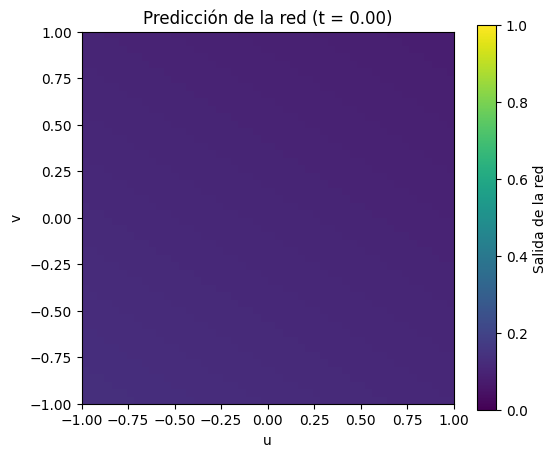

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Fijamos semilla para reproducibilidad
torch.manual_seed(0)
np.random.seed(0)

# 1. Cargar y preprocesar MNIST
# Transformación: convertir a tensor y aplanar la imagen (28x28 -> 784)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convertir etiquetas a binarias: 1 si dígito == 2, 0 en otro caso.
# Los atributos 'targets' son tensores, por lo que podemos hacer la conversión directamente.
train_dataset.targets = (train_dataset.targets == 2).float()
test_dataset.targets = (test_dataset.targets == 2).float()

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Definir la red neuronal
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = SimpleNet()
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Entrenar la red
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    running_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")



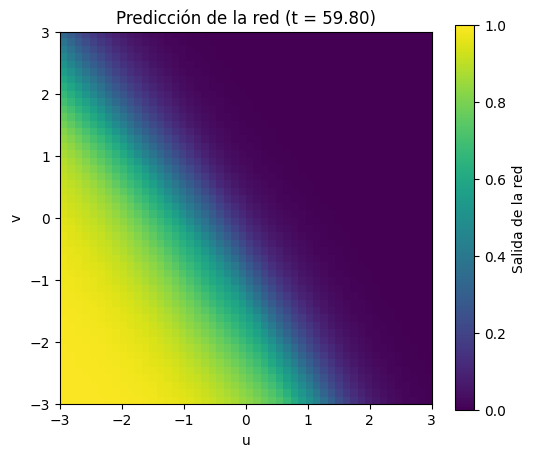

In [7]:
# -----------------------------
# 4. Calcular el centro de los datos
# -----------------------------
# Se obtiene el centro (promedio) de los inputs del conjunto de entrenamiento.
all_train_inputs = []
for inputs, _ in train_loader:
    all_train_inputs.append(inputs)
all_train_inputs = torch.cat(all_train_inputs, dim=0)  # Shape: [num_samples, 784]
center = torch.mean(all_train_inputs, dim=0)

# -----------------------------
# 5. Definir la parametrización de la 2-variedad en R^784
# -----------------------------
# Generamos 4 vectores aleatorios y los ortonormalizamos mediante QR.
def generate_orthonormal_vectors(dim, num_vecs):
    A = torch.randn(dim, num_vecs)
    Q, _ = torch.linalg.qr(A)
    return Q

v = generate_orthonormal_vectors(784, 4)
v1, v2, v3, v4 = v[:, 0], v[:, 1], v[:, 2], v[:, 3]

# La base del plano varía en el tiempo:
#   w1(t) = cos(t)*v1 + sin(t)*v3
#   w2(t) = cos(t)*v2 + sin(t)*v4
def get_rotated_basis(t):
    ct = np.cos(t)
    st = np.sin(t)
    w1 = ct * v1 + st * v3
    w2 = ct * v2 + st * v4
    return w1, w2

# Escala aumentada para "zoom out": se explora una mayor variación respecto al centro.
scale = 2.0

# Mapeo del plano: para cada par (u,v) se genera un punto en R^784
def phi(t, u, v):
    w1, w2 = get_rotated_basis(t)
    return center + scale * (u * w1 + v * w2)

# -----------------------------
# 6. Configurar la malla y evaluar la red en el plano
# -----------------------------
# Se extiende el rango de (u,v) para lograr un "zoom out". Ahora u y v varían en [-3, 3].
grid_size = 50
u_vals = np.linspace(-3, 3, grid_size)
v_vals = np.linspace(-3, 3, grid_size)
uu, vv = np.meshgrid(u_vals, v_vals)

def evaluate_plane(t):
    grid_points = []
    for i in range(grid_size):
        for j in range(grid_size):
            pt = phi(t, uu[i, j], vv[i, j])
            grid_points.append(pt.unsqueeze(0))
    grid_points = torch.cat(grid_points, dim=0)  # Shape: [grid_size^2, 784]

    model.eval()
    with torch.no_grad():
        preds = model(grid_points)
    # Se reorganizan las predicciones en forma de malla
    preds = preds.view(grid_size, grid_size).cpu().numpy()
    return preds

# -----------------------------
# 7. Configurar la animación del heatmap
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 5))
# Se actualiza el extent para que corresponda al rango de u y v [-3, 3]
heatmap = ax.imshow(np.zeros((grid_size, grid_size)), cmap='viridis',
                    vmin=0, vmax=1, origin='lower', extent=[-3, 3, -3, 3])
ax.set_title("Predicción de la red (Probabilidad de ser '2')")
ax.set_xlabel('u')
ax.set_ylabel('v')
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Salida de la red')

def update(frame):
    # Se incrementa el factor de tiempo para lograr movimientos más notorios.
    t = frame * 0.2
    heatmap_data = evaluate_plane(t)
    heatmap.set_data(heatmap_data)
    ax.set_title(f"Predicción de la red (t = {t:.2f})")
    return heatmap,

# Se incrementa el número de frames para prolongar la animación.
anim = animation.FuncAnimation(fig, update, frames=300, interval=100, blit=True)

# Para guardar la animación, descomenta la siguiente línea (requiere ffmpeg o similar):
anim.save('heatmap2.mp4', writer='ffmpeg', fps=10)

plt.show()


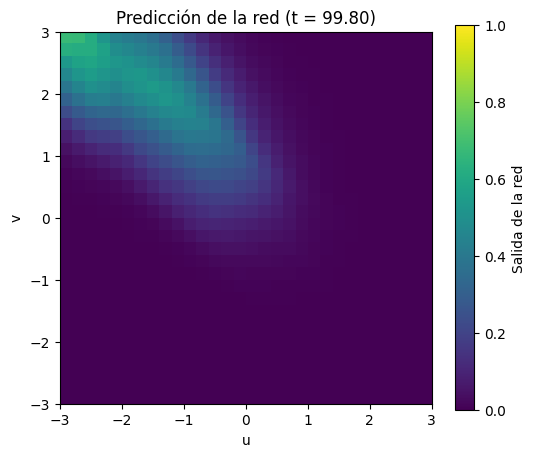

In [8]:
# -----------------------------
# 4. Calcular el centro de los datos
# -----------------------------
all_train_inputs = []
for inputs, _ in train_loader:
    all_train_inputs.append(inputs)
all_train_inputs = torch.cat(all_train_inputs, dim=0)  # Shape: [num_samples, 784]
center = torch.mean(all_train_inputs, dim=0)

# -----------------------------
# 5. Definir la parametrización de la 2-variedad en R^784 con traslación y rotación
# -----------------------------
# Generamos 4 vectores aleatorios y los ortonormalizamos mediante QR.
def generate_orthonormal_vectors(dim, num_vecs):
    A = torch.randn(dim, num_vecs)
    Q, _ = torch.linalg.qr(A)
    return Q

v = generate_orthonormal_vectors(784, 4)
v1, v2, v3, v4 = v[:, 0], v[:, 1], v[:, 2], v[:, 3]

# La base del plano varía en el tiempo: se rota mediante combinaciones de v1, v3 y de v2, v4.
def get_rotated_basis(t):
    ct = np.cos(t)
    st = np.sin(t)
    w1 = ct * v1 + st * v3
    w2 = ct * v2 + st * v4
    return w1, w2

# Parámetros para el zoom y el movimiento:
scale = 5.0  # Zoom out: la contribución de la parte del plano es mayor.
translation_speed = 0.01  # Velocidad de traslación del centro en R^784.

# Definimos un vector de drift aleatorio (normalizado) para la traslación.
drift = torch.randn(784)
drift = drift / drift.norm()

# Mapeo del plano: para cada par (u, v) se genera un punto en R^784 que depende de t.
def phi(t, u, v):
    w1, w2 = get_rotated_basis(t)
    # Se traslada el centro a lo largo del vector "drift", de forma lineal en el tiempo.
    center_t = center + drift * (translation_speed * t)
    return center_t + scale * (u * w1 + v * w2)

# -----------------------------
# 6. Configurar la malla y evaluar la red en el plano
# -----------------------------
# Se reduce la resolución para acelerar el cómputo y se extiende el rango de (u,v) a [-3, 3].
grid_size = 30
u_vals = np.linspace(-3, 3, grid_size)
v_vals = np.linspace(-3, 3, grid_size)
uu, vv = np.meshgrid(u_vals, v_vals)

def evaluate_plane(t):
    grid_points = []
    for i in range(grid_size):
        for j in range(grid_size):
            pt = phi(t, uu[i, j], vv[i, j])
            grid_points.append(pt.unsqueeze(0))
    grid_points = torch.cat(grid_points, dim=0)  # Shape: [grid_size^2, 784]

    model.eval()
    with torch.no_grad():
        preds = model(grid_points)
    # Reorganizamos las predicciones en forma de malla
    preds = preds.view(grid_size, grid_size).cpu().numpy()
    return preds

# -----------------------------
# 7. Configurar la animación del heatmap
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 5))
# Se actualiza el extent para que corresponda al rango de u y v: [-3, 3]
heatmap = ax.imshow(np.zeros((grid_size, grid_size)), cmap='viridis',
                    vmin=0, vmax=1, origin='lower', extent=[-3, 3, -3, 3])
ax.set_title("Predicción de la red (Probabilidad de ser '2')")
ax.set_xlabel('u')
ax.set_ylabel('v')
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Salida de la red')

def update(frame):
    # Se incrementa t de forma lineal para que el plano se traslade y rote.
    t = frame * 0.2
    heatmap_data = evaluate_plane(t)
    heatmap.set_data(heatmap_data)
    ax.set_title(f"Predicción de la red (t = {t:.2f})")
    return heatmap,

# Aumentamos el número de frames para un recorrido más extenso.
anim = animation.FuncAnimation(fig, update, frames=500, interval=100, blit=True)

# Para guardar la animación, descomenta la siguiente línea (se requiere tener instalado ffmpeg o similar):
anim.save('heatmap3.mp4', writer='ffmpeg', fps=10)

plt.show()
